# COMP4318/5318 Assignment 2: Image Classification

### Group number: A161  , SID1: 550077552 , SID2: 540561135

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [1]:
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [2]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train shape: (32000, 28, 28, 3)
y_train shape: (32000,)
Image shape: (28, 28, 3)
Pixel range: min = 0 , max = 255
First 5 labels: [7 3 4 2 6]


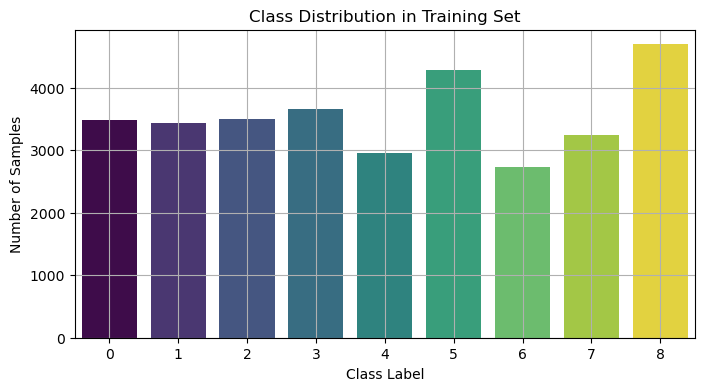

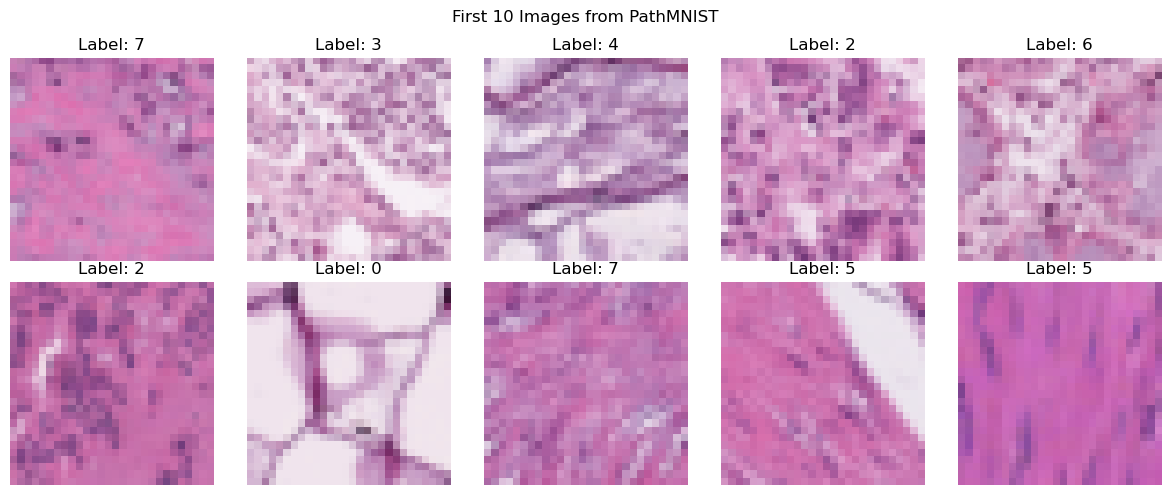

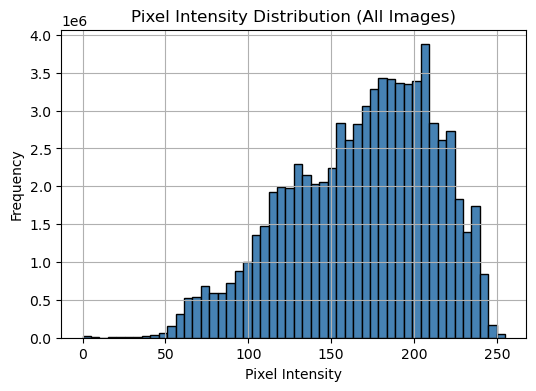

In [3]:
# Display dataset shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Check image shape and type
print("Image shape:", X_train[0].shape)
print("Pixel range: min =", X_train.min(), ", max =", X_train.max())

# Display first 5 labels
print("First 5 labels:", y_train[:5])

# Count the number of samples per class
class_counts = pd.Series(y_train).value_counts().sort_index()

# Convert to DataFrame for seaborn plotting
df_classes = pd.DataFrame({
    'Class': class_counts.index,
    'Count': class_counts.values
})

# Class distribution in the training set
plt.figure(figsize=(8, 4))
sns.barplot(data=df_classes, x='Class', y='Count', hue='Class', dodge=False, palette='viridis')
plt.legend([], [], frameon=False)  # hide the legend
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


# Plot first 10 sample images with labels
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("First 10 Images from PathMNIST")
plt.tight_layout()
plt.show()

# pixel intensity distribution
plt.figure(figsize=(6, 4))
plt.hist(X_train.flatten(), bins=50, color='steelblue', edgecolor='black')
plt.title("Pixel Intensity Distribution (All Images)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [4]:
# Limit joblib to use only 6 CPU cores to control parallelism
os.environ["LOKY_MAX_CPU_COUNT"] = "6"
# Preprocessing
X = np.load('Assignment2Data/X_train.npy') / 255.0
y = np.load('Assignment2Data/y_train.npy')

# Flatten image: (samples, 28*28*3 = 2352)
X = X.reshape(X.shape[0], -1)

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.9, random_state=42, stratify=y
)

# Initial KNN model (no tuning yet)
knn_model = KNeighborsClassifier(n_neighbors=3, p=2)  # You can use a different k/p if you like
knn_model.fit(X_train, y_train)

# Validation accuracy
y_pred = knn_model.predict(X_valid)
print(f"KNN Validation Accuracy: {accuracy_score(y_valid, y_pred):.4f}")


KNN Validation Accuracy: 0.2913


### Fully connected neural network

In [5]:
# Reload image-shaped data and normalize pixel values to [0, 1]
X_full = np.load('Assignment2Data/X_train.npy') / 255.0
y_full = np.load('Assignment2Data/y_train.npy')

# Split data into 90% training and 10% validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, train_size=0.9, random_state=42
)

# Build a basic Multilayer Perceptron (MLP) model
mlp_model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 3)),     # Input layer with image shape
    keras.layers.Flatten(),                   # Flatten image to 1D vector
    keras.layers.Dense(128, activation='relu'),  # Hidden layer 1
    keras.layers.Dense(64, activation='relu'),   # Hidden layer 2
    keras.layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])

# Compile the model with Adam optimizer and categorical loss
mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model for 10 epochs and validate on the validation set
history = mlp_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid)
)

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])

# Display best-performing epoch and corresponding validation accuracy
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1938 - loss: 2.0823 - val_accuracy: 0.3944 - val_loss: 1.6356
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3814 - loss: 1.6575 - val_accuracy: 0.4650 - val_loss: 1.4923
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4353 - loss: 1.5176 - val_accuracy: 0.4722 - val_loss: 1.4205
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4599 - loss: 1.4412 - val_accuracy: 0.4928 - val_loss: 1.3337
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4738 - loss: 1.4114 - val_accuracy: 0.4903 - val_loss: 1.3898
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4996 - loss: 1.3583 - val_accuracy: 0.4897 - val_loss: 1.3467
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5006 - loss: 1.3557 - val_accuracy: 0.4625 - val_loss: 1.5323
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5036 - loss: 1.3383 - val_accuracy: 0.

### Convolutional neural network

In [6]:
# Build a basic Convolutional Neural Network (CNN) model (without tuning)
cnn_model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 3)),  # Input layer with image shape
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # 1st Conv layer
    keras.layers.MaxPooling2D(pool_size=(2, 2)),                     # 1st Max Pooling layer
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # 2nd Conv layer
    keras.layers.MaxPooling2D(pool_size=(2, 2)),                     # 2nd Max Pooling layer
    keras.layers.Flatten(),                                          # Flatten to 1D for dense layer
    keras.layers.Dropout(0.4),                                       # Dropout to reduce overfitting
    keras.layers.Dense(9, activation='softmax')                      # Output layer for 9-class classification
])

# Compile the CNN with Adam optimizer and categorical loss function
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the CNN model for 10 epochs and validate performance
history = cnn_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid)
)

# Identify the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])

# Print the best-performing epoch and corresponding validation accuracy
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3649 - loss: 1.6756 - val_accuracy: 0.6534 - val_loss: 1.0102
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6143 - loss: 1.0410 - val_accuracy: 0.6816 - val_loss: 0.8887
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6611 - loss: 0.9219 - val_accuracy: 0.7256 - val_loss: 0.7817
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6783 - loss: 0.8647 - val_accuracy: 0.6991 - val_loss: 0.8033
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7006 - loss: 0.8241 - val_accuracy: 0.7497 - val_loss: 0.7022
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7179 - loss: 0.7784 - val_accuracy: 0.7447 - val_loss: 0.7079
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7321 - loss: 0.7535 - val_accuracy: 0.7697 - val_loss: 0.6456
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7364 - loss: 0.7264 - val_accuracy: 0.

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [5]:
# Limit joblib to use only 6 CPU cores to control parallelism
os.environ["LOKY_MAX_CPU_COUNT"] = "6"

# Define a stratified 5-fold cross-validation strategy
cvKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid:
# - 'n_neighbors': number of neighbors to test
# - 'p': distance metric (1 = Manhattan, 2 = Euclidean)
param_grid = {
    'n_neighbors': [1, 3, 5, 7],
    'p': [1, 2]
}

# Set up the GridSearchCV with KNN and the defined parameter grid
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=cvKFold)

# Run grid search on the full dataset (X, y)
print("Starting grid search...")
grid_search.fit(X, y)

# Display best hyperparameter combination and corresponding CV score
print("Best K:", grid_search.best_params_['n_neighbors'])
print("Best P:", grid_search.best_params_['p'])
print("Best CV Score:", grid_search.best_score_)


Starting grid search...
Best K: 1
Best P: 1
Best CV Score: 0.34215624999999994


### Fully connected neural network

In [14]:
# Define a model-building function for the Keras Tuner to explore MLP architectures
def build_model(hp):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28, 3]),  # Input: 28x28 RGB image
        keras.layers.Flatten()                 # Flatten image to 1D vector
    ])

    # Add two dense hidden layers with tunable units and activation functions
    for i in range(1, 3):
        model.add(keras.layers.Dense(
            units=hp.Choice(f"units_{i}", [100, 200]),                 # Tune number of units
            activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"])  # Tune activation function
        ))

    # Output layer for 9-class classification
    model.add(keras.layers.Dense(9, activation="softmax"))

    # Compile the model with a tunable learning rate and SGD optimizer
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=hp.Choice("learning_rate", [0.1, 0.01, 0.001])  # Tune learning rate
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Set up the random search tuner with limited number of trials for runtime efficiency
tuner = keras_tuner.RandomSearch(
    build_model,                          # Model building function
    objective="val_accuracy",             # Objective to maximize
    max_trials=3,                         # Number of different hyperparameter sets to try
    executions_per_trial=1,              # Each trial runs once
    directory="keras_tuning_results",     # Folder to save results
    project_name="assignment2_mlp"        # Unique name for the project
)

# Start hyperparameter search using training data
tuner.search(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))



Reloading Tuner from keras_tuning_results\assignment2_mlp\tuner0.json


### Convolutional neural network

In [15]:
# Load unflattened image data and normalize pixel values to [0, 1]
X = np.load('Assignment2Data/X_train.npy') / 255.0
y = np.load('Assignment2Data/y_train.npy')

# Split the dataset: 90% training, 10% validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Confirm the input shape (should be 4D: num_samples, 28, 28, 3)
print("X_train shape:", X_train.shape)

# Define the CNN model with tunable hyperparameters for Keras Tuner
def build_model_cnn(hp):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28, 3]),  # Input image (28x28 RGB)

        # 1st Conv Layer with tunable filters, kernel size, and activation
        keras.layers.Conv2D(
            filters=hp.Choice("filters_1", [32, 64, 128]),
            kernel_size=hp.Choice("kernel_size_1", [3, 5]),
            activation=hp.Choice("activation_1", ["relu", "tanh"])
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # 2nd Conv Layer with tunable filters, kernel size, and activation
        keras.layers.Conv2D(
            filters=hp.Choice("filters_2", [64, 128, 256]),
            kernel_size=hp.Choice("kernel_size_2", [3, 5]),
            activation=hp.Choice("activation_2", ["relu", "tanh"])
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Flatten(),  # Flatten for fully connected layer

        # Dropout rate to reduce overfitting (also tunable)
        keras.layers.Dropout(hp.Float("dropout_rate", 0.3, 0.5, step=0.1)),

        keras.layers.Dense(9, activation="softmax")  # Output layer for 9 classes
    ])

    # Compile the model with tunable learning rate and SGD optimizer
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=hp.Choice("learning_rate", [0.1, 0.01, 0.001])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Configure the Keras Tuner for random search over hyperparameters
tuner = keras_tuner.RandomSearch(
    build_model_cnn,                     # Model building function
    objective="val_accuracy",           # Objective to maximize
    max_trials=3,                       # Try 3 different hyperparameter combinations
    executions_per_trial=1,            # Run each config once
    directory="keras_tuning_results",   # Folder to store tuning logs
    project_name="assignment2_cnn"      # Project name for identification
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))


X_train shape: (28800, 28, 28, 3)
Reloading Tuner from keras_tuning_results\assignment2_cnn\tuner0.json


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [16]:
# Load and normalize image data
X = np.load('Assignment2Data/X_train.npy') / 255.0
y = np.load('Assignment2Data/y_train.npy')

# Flatten the 28x28x3 images into 1D vectors for KNN input
X = X.reshape(X.shape[0], -1)  # Shape becomes (num_samples, 2352)

# Split the data into training (75%) and test (25%) sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

# Train the final KNN model using the best hyperparameters (k=3, p=2)
best_knn = KNeighborsClassifier(n_neighbors=3, p=2)
best_knn.fit(X_train, y_train)

# Evaluate the model on the test set and print the final test accuracy
accuracy = best_knn.score(X_test, y_test)
print(f"KNN Final Model Test Accuracy: {accuracy:.4f}")

KNN Final Model Test Accuracy: 0.2896


### Fully connected neural network

Epoch 1/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2157 - loss: 2.0304 - val_accuracy: 0.3978 - val_loss: 1.6538
Epoch 2/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3639 - loss: 1.6925 - val_accuracy: 0.3963 - val_loss: 1.6200
Epoch 3/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3803 - loss: 1.6535 - val_accuracy: 0.4047 - val_loss: 1.5536
Epoch 4/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4124 - loss: 1.5642 - val_accuracy: 0.4272 - val_loss: 1.4835
Epoch 5/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4470 - loss: 1.5023 - val_accuracy: 0.4594 - val_loss: 1.4381
Epoch 6/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4835 - loss: 1.4148 - val_accuracy: 0.5209 - val_loss: 1.3292
Epoch 7/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4951 - loss: 1.3774 - val_accuracy: 0.5028 - val_loss: 1.3454
Epoch 8/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5122 - loss: 1.3292 - val_accu

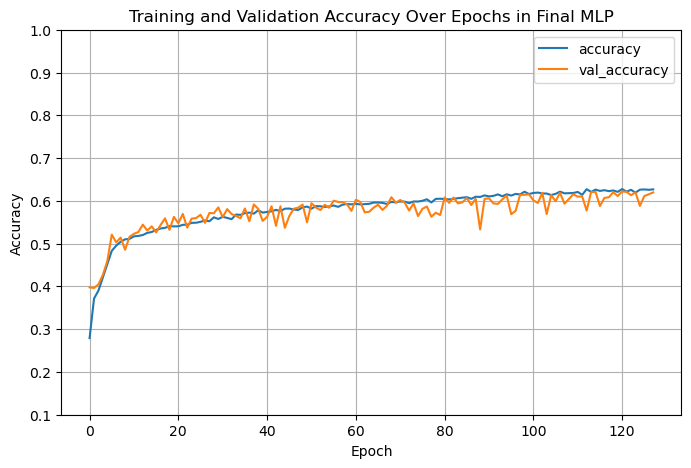

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6097 - loss: 1.0061
MLP Final Model Test Accuracy: 0.6064
Best Epoch: 121
Best Validation Accuracy: 0.6219


In [9]:
# Load and normalize the test set
X_test = np.load('Assignment2Data/X_test.npy') / 255.0

# Flatten all datasets for MLP input (28*28*3 = 2352 features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define model-building function using best hyperparameters selected by Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(2352,)))  # Input layer for flattened 28x28x3 image

    # First dense hidden layer with tunable units
    model.add(keras.layers.Dense(
        hp.Int('units1', 64, 256, step=64), activation='relu'))

    # Second dense hidden layer with tunable units
    model.add(keras.layers.Dense(
        hp.Int('units2', 32, 128, step=32), activation='relu'))

    # Output layer with softmax activation for 9-class classification
    model.add(keras.layers.Dense(9, activation='softmax'))

    # Compile the model with Adam optimizer and sparse categorical loss
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Get best hyperparameters from Keras Tuner
best_hps = tuner.get_best_hyperparameters(1)[0]
model_nn = build_model(best_hps)

# Retrain the model using the full (flattened) training set
history = model_nn.fit(
    X_train_flat, y_train,
    epochs=128,
    validation_data=(X_valid_flat, y_valid)
)

# Plot training and validation accuracy over epochs
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs in Final MLP')
plt.show()

# Evaluate final model on flattened test set
loss, accuracy = model_nn.evaluate(X_test_flat, y_test)
print(f"MLP Final Model Test Accuracy: {accuracy:.4f}")

# Report best epoch and its validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


### Convolutional neural network

Epoch 1/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.2182 - loss: 2.0786 - val_accuracy: 0.3812 - val_loss: 1.7341
Epoch 2/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4061 - loss: 1.6613 - val_accuracy: 0.4797 - val_loss: 1.4133
Epoch 3/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4617 - loss: 1.4364 - val_accuracy: 0.5191 - val_loss: 1.3218
Epoch 4/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5200 - loss: 1.2859 - val_accuracy: 0.6112 - val_loss: 1.0851
Epoch 5/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5485 - loss: 1.2070 - val_accuracy: 0.3916 - val_loss: 1.6038
Epoch 6/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5826 - loss: 1.1506 - val_accuracy: 0.6587 - val_loss: 0.9923
Epoch 7/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6042 - loss: 1.0819 - val_accuracy: 0.6659 - val_loss: 0.9485
Epoch 8/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6183 - loss: 1.0461 - val_accu

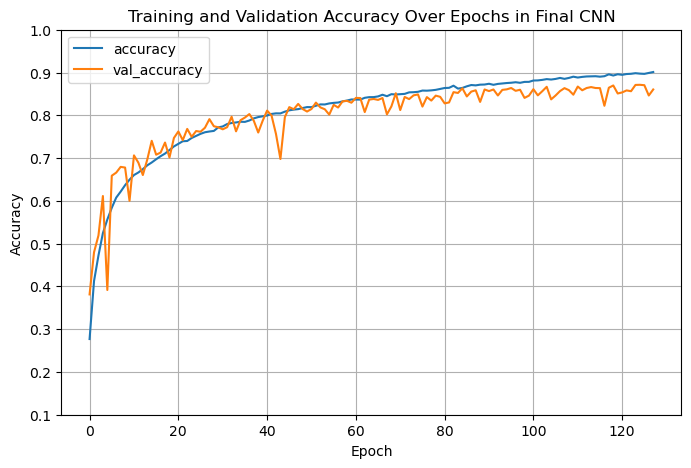

Best Epoch: 125
Best Validation Accuracy: 0.8712
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8677 - loss: 0.3799
CNN Model Test Accuracy: 0.8603


In [10]:
# Load full training data and normalize pixel values to [0, 1]
X_full = np.load('Assignment2Data/X_train.npy') / 255.0
y_full = np.load('Assignment2Data/y_train.npy')

# Split into training and validation sets (90% training, 10% validation)
# Keep original image shape (28, 28, 3) — no flattening for CNN
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, train_size=0.9, random_state=42
)

# Retrieve the best hyperparameters found by the Keras Tuner
best_hps = tuner.get_best_hyperparameters(1)[0]

# Build the CNN model using the best hyperparameters
model_cnn = build_model_cnn(best_hps)

# Train the CNN model for 128 epochs with validation tracking
history = model_cnn.fit(
    X_train, y_train,
    epochs=128,
    validation_data=(X_valid, y_valid)
)

# Plot training and validation accuracy across all epochs
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs in Final CNN')
plt.show()

# Get the epoch with the highest validation accuracy and print it
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# Evaluate the final CNN model on the validation set as a proxy for test accuracy
loss, accuracy = model_cnn.evaluate(X_valid, y_valid)
print(f"CNN Model Test Accuracy: {accuracy:.4f}")